In [5]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from bs4 import BeautifulSoup
from gensim.summarization import summarize
import textwrap

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import spacy
nlp = spacy.load("en_core_web_lg", disable=['parser', 'tagger', 'ner'])

In [6]:
print(f'Gensim Version:',{gensim.__version__}) 

Gensim Version: {'3.8.1'}


In [10]:
df = pd.read_csv('/Users/jasonrobinson/Downloads/reviews.csv')
print(df.shape)
df.head(2)

(847727, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.


In [11]:
df.dropna(subset=['comments'],how='any',axis=0,inplace=True)

In [12]:
import re
import string

num = lambda x: re.sub('\w*\d\w*', ' ', x)
lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [13]:
#df['comments'] = df['comments'].map(num).map(lower)

In [14]:
df['clean_comments'] = df['comments'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_comments'] = df['clean_comments'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_comments'] = df['clean_comments'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace and lowercase text
df['clean_comments'] = df['clean_comments'].apply(lambda x: ' '.join(x.lower().split()))

In [16]:
df.sample(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,clean_comments
239951,5261913,583289127,2019-12-28,159497601,Anaël,Very well located between Times Square and Cen...,very well located between times square and cen...
528897,18439203,263284631,2018-05-11,157778927,Karlien,Very nice and clean appartment and also a very...,very nice and clean appartment and also a very...


In [32]:
#vectorizer = TfidfVectorizer(min_df=53, max_features=50, stop_words='english',ngram_range=(1,1))
#feature_matrix = vectorizer.fit_transform(df['comments'])
#print(feature_matrix.shape)

(847031, 50)


In [17]:
# create our tokens in the form of lemmas
from tqdm import tqdm
tqdm.pandas()

df['lemmas'] = df['clean_comments'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2)])

100%|██████████| 847031/847031 [01:28<00:00, 9531.06it/s] 


In [18]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,clean_comments,lemmas
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...,notre s jour de trois nuits nous avons appr ci...,"[notre, jour, trois, nuits, nous, avons, appr,..."
1,2595,19176,2009-12-05,53267,Cate,Great experience.,great experience,"[great, experience]"


In [35]:
#X_train, y_train = train_test_split(df, df['comments'], train_size=0.8,
#                                                    stratify=df['comments'], random_state=42)

In [19]:
# Two main inputs of a LDA model dictionary and corpus.

id2word = corpora.Dictionary(df['lemmas'])
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [20]:
# Filter out extreme outliers to reduce our dictionary size.
id2word.filter_extremes(no_below=2, no_above=0.5)

In [21]:
len(id2word.keys())

71400

In [39]:
df.lemmas.iloc[5][:3]

['great', 'compliment', 'jennifer']

In [40]:
[(id2word[word_id], word_count) for word_id, word_count in corpus[0]]

[('able', 1),
 ('agr', 1),
 ('appartement', 1),
 ('appr', 1),
 ('arrivant', 1),
 ('aussi', 1),
 ('avait', 1),
 ('avons', 2),
 ('bien', 3),
 ('bruit', 1),
 ('castle', 1),
 ('caution', 1),
 ('ces', 1),
 ('cier', 1),
 ('correcte', 1),
 ('court', 1),
 ('difficile', 1),
 ('donc', 1),
 ('douche', 1),
 ('est', 5),
 ('famille', 1),
 ('habitu', 1),
 ('ile', 1),
 ('jean', 1),
 ('jennifer', 1),
 ('jour', 2),
 ('les', 2),
 ('liquide', 1),
 ('manquait', 1),
 ('midtown', 1),
 ('notre', 2),
 ('nous', 3),
 ('nuit', 1),
 ('nuits', 1),
 ('pas', 1),
 ('pass', 1),
 ('personne', 1),
 ('personnes', 1),
 ('petits', 2),
 ('possession', 1),
 ('possibilit', 1),
 ('pour', 4),
 ('premi', 1),
 ('propre', 1),
 ('qui', 1),
 ('rapide', 1),
 ('recevoir', 1),
 ('remboursement', 1),
 ('reprendrai', 1),
 ('revenir', 1),
 ('savon', 1),
 ('situ', 1),
 ('soign', 1),
 ('soucis', 1),
 ('sur', 1),
 ('surlendemain', 1),
 ('tail', 1),
 ('tait', 1),
 ('tro', 1),
 ('trois', 1),
 ('une', 2),
 ('union', 1),
 ('vacances', 1),
 ('vais

In [26]:
### Re-create DTM
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [27]:
%%time
# Train our model
comment_lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=20, 
                                              chunksize=100,
                                              passes=2,
                                              per_word_topics=True)


comment_lda.save('comment_lda2.model')

CPU times: user 33min 15s, sys: 38.1 s, total: 33min 53s
Wall time: 33min 54s


In [23]:
%%time
#lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
#                                                        id2word=id2word,
#                                                        num_topics=20, 
#                                                        chunksize=100,
#                                                        passes=5,
#                                                        per_word_topics=True,
#                                                        workers=6)
#
#
#lda_multicore.save('lda_multicore.model')

KeyboardInterrupt: 

In [30]:
## from gensim import models
#comment_lda =  models.LdaModel.load('comment_lda2.model')

In [29]:
pprint(comment_lda.print_topics())

[(0,
  '0.202*"quick" + 0.166*"responsive" + 0.156*"respond" + 0.101*"issue" + '
  '0.077*"quickly" + 0.058*"list" + 0.049*"service" + 0.041*"message" + '
  '0.029*"entire" + 0.022*"backyard"'),
 (1,
  '0.073*"stay" + 0.068*"place" + 0.043*"home" + 0.036*"feel" + 0.030*"clean" '
  '+ 0.030*"well" + 0.028*"cozy" + 0.028*"like" + 0.027*"host" + '
  '0.026*"definitely"'),
 (2,
  '0.344*"airbnb" + 0.123*"shower" + 0.105*"take" + 0.072*"care" + '
  '0.055*"wrong" + 0.044*"point" + 0.042*"hide" + 0.041*"fine" + 0.039*"ideal" '
  '+ 0.022*"chair"'),
 (3,
  '0.159*"muy" + 0.094*"que" + 0.080*"con" + 0.057*"todo" + 0.054*"para" + '
  '0.052*"una" + 0.035*"ubicaci" + 0.032*"est" + 0.031*"bien" + 0.030*"por"'),
 (4,
  '0.077*"bedroom" + 0.055*"kitchen" + 0.051*"area" + 0.050*"value" + '
  '0.049*"private" + 0.045*"cool" + 0.044*"pretty" + 0.040*"door" + '
  '0.037*"bathroom" + 0.035*"travel"'),
 (5,
  '0.196*"awesome" + 0.192*"excellent" + 0.137*"don" + 0.071*"host" + '
  '0.042*"win" + 0.039*"ex

In [32]:
doc_lda = comment_lda[corpus]
doc_lda[1][0]

[(0, 0.016666787),
 (1, 0.016666789),
 (2, 0.016666787),
 (3, 0.016666787),
 (4, 0.016666787),
 (5, 0.016666787),
 (6, 0.016666787),
 (7, 0.016666787),
 (8, 0.016666787),
 (9, 0.016666787),
 (10, 0.016666787),
 (11, 0.016666787),
 (12, 0.016666787),
 (13, 0.016666787),
 (14, 0.016666787),
 (15, 0.016666787),
 (16, 0.683331),
 (17, 0.016666787),
 (18, 0.016666787),
 (19, 0.016666787)]

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(comment_lda, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.290499 -0.008020       1        1  15.127698
12    -0.285610 -0.081646       2        1  15.066296
6     -0.068809 -0.252881       3        1  11.557452
9     -0.349404  0.109697       4        1   9.411896
13    -0.016623 -0.272665       5        1   8.288113
14    -0.247871  0.074604       6        1   5.506691
10     0.172669  0.039406       7        1   4.086380
4      0.060812 -0.217703       8        1   3.722654
3      0.151977  0.051850       9        1   3.711077
16    -0.264822  0.119460      10        1   3.401202
7      0.101144 -0.088937      11        1   3.340338
17     0.035662  0.153813      12        1   2.688337
8      0.138364 -0.005930      13        1   2.333116
0      0.125754  0.028922      14        1   2.044388
2      0.136159  0.052437      15        1   1.987111
15     0.092307 -0.042674      16        1   1.932692
18     0.140963  0.038066      17        1   1.871608
5      0.069925  0.173252      18        1   1.747173
11     0.140212  0.051040      19        1   1.401453
19     0.157690  0.077909      20        1   0.774325, topic_info=            Term           Freq          Total Category  logprob  loglift
65         great  575240.000000  575240.000000  Default  30.0000  30.0000
284        check  267652.000000  267652.000000  Default  29.0000  29.0000
84         place  707474.000000  707474.000000  Default  28.0000  28.0000
223         nice  257940.000000  257940.000000  Default  27.0000  27.0000
90          stay  633100.000000  633100.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
2421         far       0.187799       3.327016  Topic20 -13.6173   1.9865
1874      limpio       0.187820       3.328125  Topic20 -13.6172   1.9863
2007       lugar       0.187842       3.329894  Topic20 -13.6170   1.9858
1715       buena       0.187813       3.328004  Topic20 -13.6172   1.9863
1109  absolutely       0.187799       3.327173  Topic20 -13.6173   1.9864

[824 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
415       3  0.999756     2
415       7  0.000067     2
0         5  0.214214  able
0         7  0.636950  able
0         8  0.059081  able
...     ...       ...   ...
742       7  0.000124  year
97        5  0.999951  york
97        7  0.000016  york
791       7  0.000386  zona
791      15  0.998841  zona

[1415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 13, 7, 10, 14, 15, 11, 5, 4, 17, 8, 18, 9, 1, 3, 16, 19, 6, 12, 20])

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=6)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=22, step=4)

In [38]:
# use these values for the plot if compute_coherence_values takes too long to run 
coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

Traceback (most recent call last):
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/connection.py", line 405, in _send_bytes
    self._send(buf)
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/NNs/lib/python3.8/multiprocessing/connection.py", line 404, in _send_bytes
    self._se

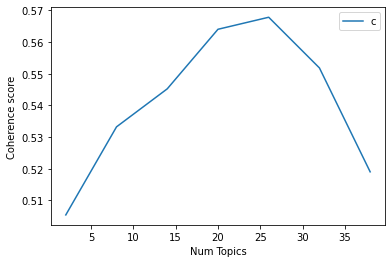

In [39]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5054
Num Topics = 8  has Coherence Value of 0.5332
Num Topics = 14  has Coherence Value of 0.5452
Num Topics = 20  has Coherence Value of 0.564
Num Topics = 26  has Coherence Value of 0.5678
Num Topics = 32  has Coherence Value of 0.5518
Num Topics = 38  has Coherence Value of 0.519


In [46]:
optimal_model =  gensim.models.LdaModel.load('comment_lda2.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.202*"quick" + 0.166*"responsive" + 0.156*"respond" + 0.101*"issue" + '
  '0.077*"quickly" + 0.058*"list" + 0.049*"service" + 0.041*"message" + '
  '0.029*"entire" + 0.022*"backyard"'),
 (1,
  '0.073*"stay" + 0.068*"place" + 0.043*"home" + 0.036*"feel" + 0.030*"clean" '
  '+ 0.030*"well" + 0.028*"cozy" + 0.028*"like" + 0.027*"host" + '
  '0.026*"definitely"'),
 (2,
  '0.344*"airbnb" + 0.123*"shower" + 0.105*"take" + 0.072*"care" + '
  '0.055*"wrong" + 0.044*"point" + 0.042*"hide" + 0.041*"fine" + 0.039*"ideal" '
  '+ 0.022*"chair"'),
 (3,
  '0.159*"muy" + 0.094*"que" + 0.080*"con" + 0.057*"todo" + 0.054*"para" + '
  '0.052*"una" + 0.035*"ubicaci" + 0.032*"est" + 0.031*"bien" + 0.030*"por"'),
 (4,
  '0.077*"bedroom" + 0.055*"kitchen" + 0.051*"area" + 0.050*"value" + '
  '0.049*"private" + 0.045*"cool" + 0.044*"pretty" + 0.040*"door" + '
  '0.037*"bathroom" + 0.035*"travel"'),
 (5,
  '0.196*"awesome" + 0.192*"excellent" + 0.137*"don" + 0.071*"host" + '
  '0.042*"win" + 0.039*"ex